In [1]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind

# Configuración
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames


# Gestión de los warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../../files/df_nulos_imputados.csv", index_col=0)

Revisamos las tres columnas de satisfacción y sus medias/medianas

In [3]:
df[['EnvironmentSatisfaction' , 'JobSatisfaction' , 'RelationshipSatisfaction']].agg(['mean' , 'median'])

,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction
mean,2.714012,2.730646,2.714012
median,3.000000,3.000000,3.000000


- Observaciones: Dado que las tres medias de las columnas son similares, crearemos una nueva columna llamada Overall Satisfaction para medir la satisfacción general del empleado en base a ellas

Creamos la columna de Overall Satisfaction haciendo la media

In [4]:
df['OverallSatisfaction'] = round((df['JobSatisfaction'] + df['EnvironmentSatisfaction'] + df['RelationshipSatisfaction']) / 3, 0)
df['OverallSatisfaction'] = df['OverallSatisfaction'].astype('int64')

Creamos la columna de satisfacción en base al Overall Satisfaction

In [5]:
df['TestGroup'] = df['OverallSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

Hacemos una tabla de contingencia y analizamos los datos

In [6]:
tabla_contingencia = pd.crosstab(df['TestGroup'], df['Attrition']) 

In [7]:
# Calcular el porcentaje para 'No' en cada fila
tabla_contingencia['No %'] = tabla_contingencia['No'] / (tabla_contingencia['No'] + tabla_contingencia['Yes']) * 100

# Usar los valores originales de 'Yes' para calcular el porcentaje en cada fila
tabla_contingencia['Yes %'] = tabla_contingencia['Yes'] / (tabla_contingencia['No'] + tabla_contingencia['Yes']) * 100

tabla_contingencia

Attrition,No,Yes,No %,Yes %
TestGroup,,,,
insatisfechos,441,123,78.191489,21.808511
satisfechos,870,129,87.087087,12.912913


Establecemos las hipótesis:
- H0 : No existe una relación entre el nivel de satisfacción general en el trabajo y la rotación de empleados en la empresa
- H1: Existe una relación entre el nivel de satisfacción general en el trabajo y la rotación de empleados en la empresa

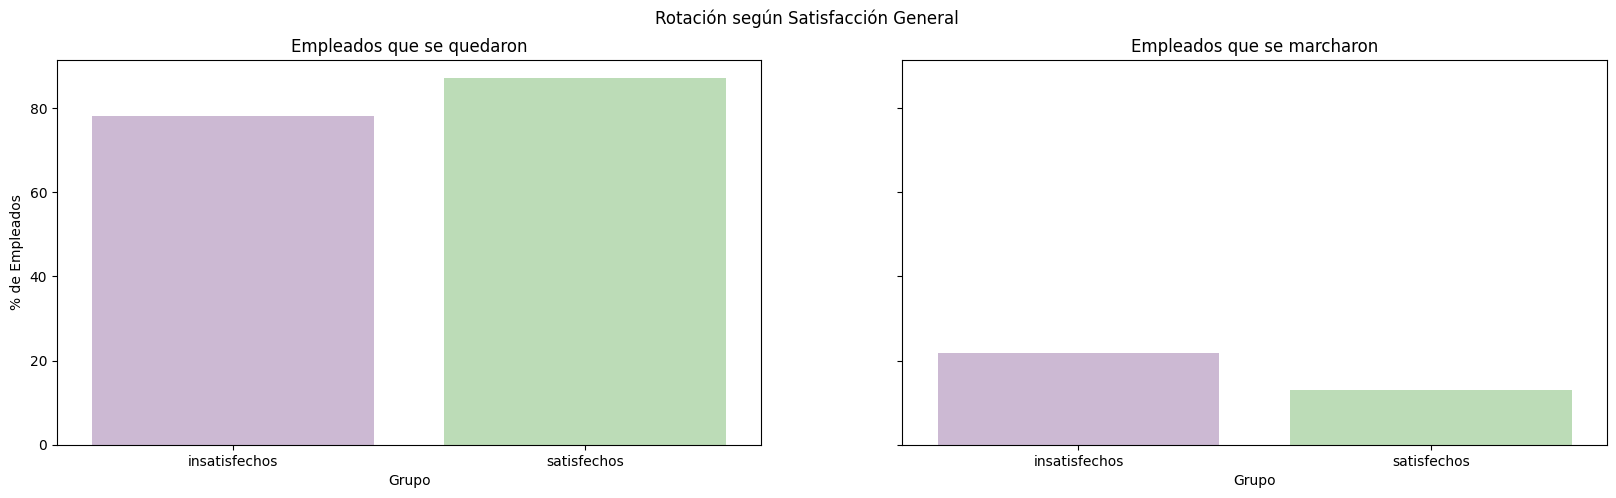

In [8]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia.index, y="No %", data=tabla_contingencia,  palette = "PRGn", ax = axes[0])
sns.barplot(x=tabla_contingencia.index, y="Yes %", data=tabla_contingencia,  palette = "PRGn", ax = axes[1])

fig.suptitle("Rotación según Satisfacción General")

axes[0].set_title("Empleados que se quedaron")
axes[1].set_title("Empleados que se marcharon")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("% de Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("% de Empleados");

In [9]:
# Realizar la prueba de proporciones
chi2, p_value, _, _ = chi2_contingency(tabla_contingencia)

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print(f"Con un p_value de {p_value} hay una diferencia significativa en la cantidad de attrition según el grupo")
else:
    print(f"Con un p_value de {p_value} no hay una diferencia significativa en la cantidad de attrition según el grupo")

Con un p_value de 2.4631804095137754e-08 hay una diferencia significativa en la cantidad de attrition según el grupo


- Conclusión: Existe una diferencia significativa en la cantidad de attrition según el grupo de satisfacción, por lo que la hipótesis H0 quedaría descartada. Sí hay una relación entre la satisfacción general de los empleados y su rotación.

Revisión según Environment Satisfaction

In [10]:
df2 = df.copy()

df2['Test_Env'] = df2['EnvironmentSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

In [11]:
tabla_contingencia2 = pd.crosstab(df2['Test_Env'], df2['Attrition']) 

# Calcular el porcentaje para 'No' en cada fila
tabla_contingencia2['No %'] = tabla_contingencia2['No'] / (tabla_contingencia2['No'] + tabla_contingencia2['Yes']) * 100

# Usar los valores originales de 'Yes' para calcular el porcentaje en cada fila
tabla_contingencia2['Yes %'] = tabla_contingencia2['Yes'] / (tabla_contingencia2['No'] + tabla_contingencia2['Yes']) * 100

tabla_contingencia2

Attrition,No,Yes,No %,Yes %
Test_Env,,,,
insatisfechos,495,126,79.710145,20.289855
satisfechos,816,126,86.624204,13.375796


Establecemos las hipótesis:
- H0 : No existe una relación entre el nivel de satisfacción con el ambiente laboral en el trabajo y la rotación de empleados en la empresa
- H1: Existe una relación entre el nivel de satisfacción con el ambiente laboral en el trabajo y la rotación de empleados en la empresa

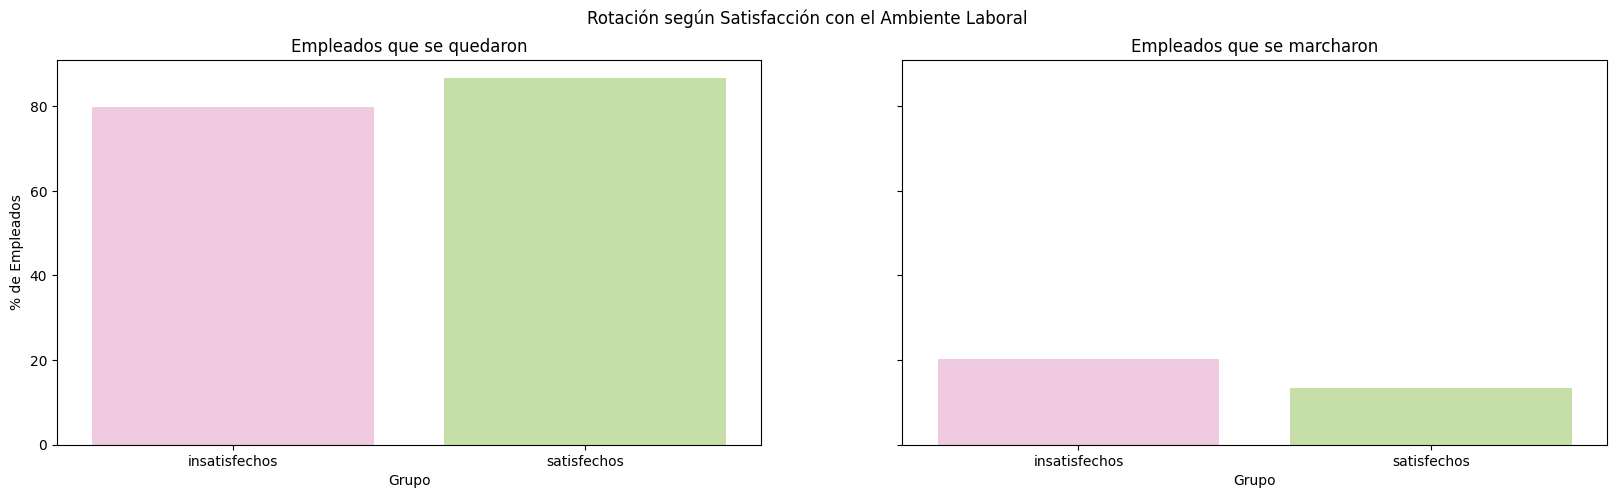

In [12]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia2.index, y="No %", data=tabla_contingencia2,  palette = "PiYG", ax = axes[0])
sns.barplot(x=tabla_contingencia2.index, y="Yes %", data=tabla_contingencia2,  palette = "PiYG", ax = axes[1])

fig.suptitle("Rotación según Satisfacción con el Ambiente Laboral")

axes[0].set_title("Empleados que se quedaron")
axes[1].set_title("Empleados que se marcharon")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("% de Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("% de Empleados");

In [13]:
# Realizar la prueba de proporciones
chi2, p_value, _, _ = chi2_contingency(tabla_contingencia2)

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print(f"Con un p_value de {p_value} hay una diferencia significativa en la cantidad de attrition según el grupo")
else:
    print(f"Con un p_value de {p_value} no hay una diferencia significativa en la cantidad de attrition según el grupo")

Con un p_value de 4.874605803063882e-05 hay una diferencia significativa en la cantidad de attrition según el grupo


- Conclusión: Existe una diferencia significativa en la cantidad de attrition según el grupo de satisfacción, por lo que la hipótesis H0 quedaría descartada. Sí hay una relación entre la satisfacción con el ambiente laboral y la rotación de los empleados.

Revisión según Job Satisfaction

In [14]:
df2['Test_Job'] = df2['JobSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

In [15]:
tabla_contingencia3 = pd.crosstab(df2['Test_Job'], df2['Attrition']) 

# Calcular el porcentaje para 'No' en cada fila
tabla_contingencia3['No %'] = tabla_contingencia3['No'] / (tabla_contingencia3['No'] + tabla_contingencia3['Yes']) * 100

# Usar los valores originales de 'Yes' para calcular el porcentaje en cada fila
tabla_contingencia3['Yes %'] = tabla_contingencia3['Yes'] / (tabla_contingencia3['No'] + tabla_contingencia3['Yes']) * 100

tabla_contingencia3

Attrition,No,Yes,No %,Yes %
Test_Job,,,,
insatisfechos,486,121,80.065898,19.934102
satisfechos,825,131,86.297071,13.702929


Establecemos las hipótesis:
- H0 : No existe una relación entre el nivel de satisfacción con el trabajo y la rotación de empleados en la empresa
- H1: Existe una relación entre el nivel de satisfacción con el trabajo y la rotación de empleados en la empresa

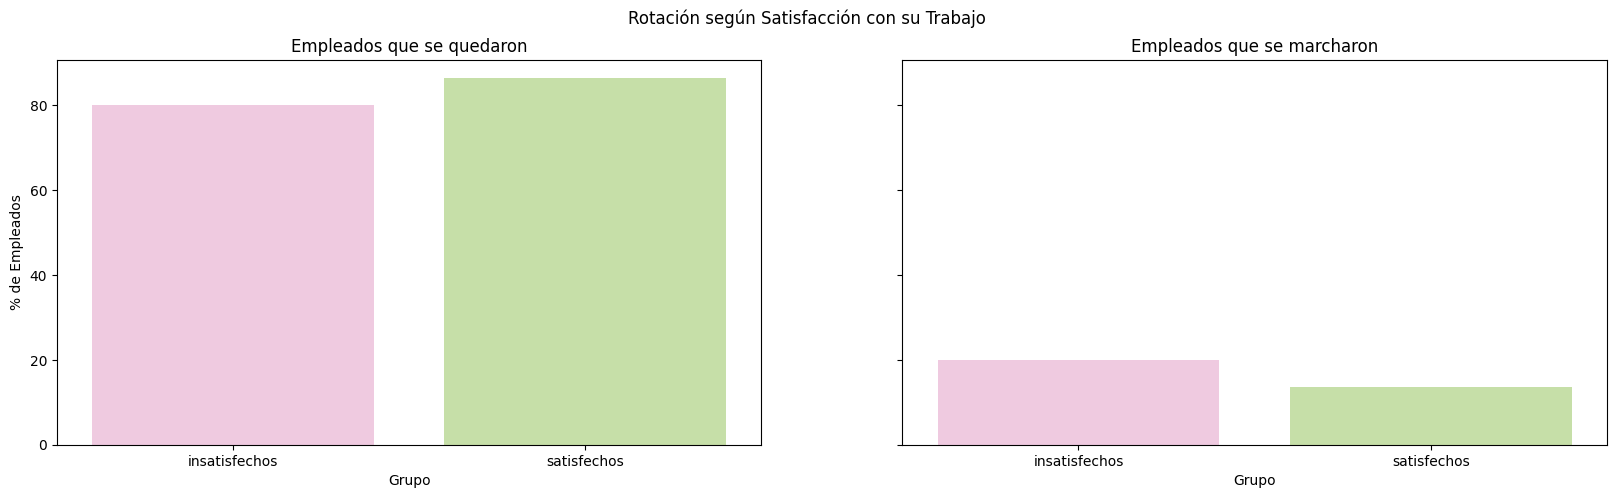

In [16]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia3.index, y="No %", data=tabla_contingencia3,  palette = "PiYG", ax = axes[0])
sns.barplot(x=tabla_contingencia3.index, y="Yes %", data=tabla_contingencia3,  palette = "PiYG", ax = axes[1])

fig.suptitle("Rotación según Satisfacción con su Trabajo")

axes[0].set_title("Empleados que se quedaron")
axes[1].set_title("Empleados que se marcharon")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("% de Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("% de Empleados");

In [17]:
# Realizar la prueba de proporciones
chi2, p_value, _, _ = chi2_contingency(tabla_contingencia3)

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print(f"Con un p_value de {p_value} hay una diferencia significativa en la cantidad de attrition según el grupo")
else:
    print(f"Con un p_value de {p_value} no hay una diferencia significativa en la cantidad de attrition según el grupo")

Con un p_value de 9.629446727636446e-05 hay una diferencia significativa en la cantidad de attrition según el grupo


- Conclusión: Existe una diferencia significativa en la cantidad de attrition según el grupo de satisfacción, por lo que la hipótesis H0 quedaría descartada. Sí hay una relación entre la satisfacción con el trabajo y la rotación de los empleados.

Revisión según Relationship Satisfaction

In [18]:
df2['Test_Rel'] = df2['RelationshipSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

In [19]:
tabla_contingencia4 = pd.crosstab(df2['Test_Rel'], df2['Attrition']) 

# Calcular el porcentaje para 'No' en cada fila
tabla_contingencia4['No %'] = tabla_contingencia4['No'] / (tabla_contingencia4['No'] + tabla_contingencia4['Yes']) * 100

# Usar los valores originales de 'Yes' para calcular el porcentaje en cada fila
tabla_contingencia4['Yes %'] = tabla_contingencia4['Yes'] / (tabla_contingencia4['No'] + tabla_contingencia4['Yes']) * 100

tabla_contingencia4

Attrition,No,Yes,No %,Yes %
Test_Rel,,,,
insatisfechos,511,106,82.820097,17.179903
satisfechos,800,146,84.566596,15.433404


Establecemos las hipótesis:
- H0 : No existe una relación entre el nivel de satisfacción con las relaciones en el trabajo y la rotación de empleados en la empresa
- H1: Existe una relación entre el nivel de satisfacción con las relaciones en el trabajo y la rotación de empleados en la empresa

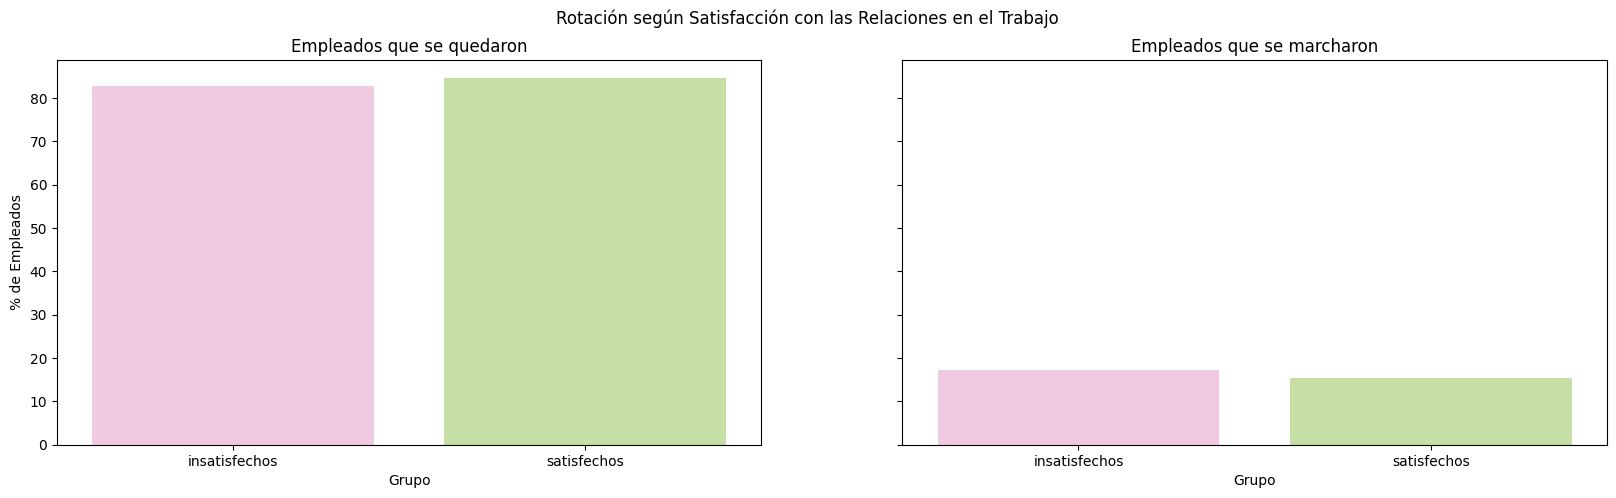

In [20]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia4.index, y="No %", data=tabla_contingencia4,  palette = "PiYG", ax = axes[0])
sns.barplot(x=tabla_contingencia4.index, y="Yes %", data=tabla_contingencia4,  palette = "PiYG", ax = axes[1])

fig.suptitle("Rotación según Satisfacción con las Relaciones en el Trabajo")

axes[0].set_title("Empleados que se quedaron")
axes[1].set_title("Empleados que se marcharon")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("% de Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("% de Empleados");

In [21]:
# Realizar la prueba de proporciones
chi2, p_value, _, _ = chi2_contingency(tabla_contingencia4)

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print(f"Con un p_value de {p_value} hay una diferencia significativa en la cantidad de attrition según el grupo")
else:
    print(f"Con un p_value de {p_value} no hay una diferencia significativa en la cantidad de attrition según el grupo")

Con un p_value de 0.028125138572455414 hay una diferencia significativa en la cantidad de attrition según el grupo


- Conclusión: No existe una diferencia significativa en la cantidad de attrition según el grupo de satisfacción, por lo que la hipótesis H0 no se podría descartar. No existe una relación entre el nivel de satisfacción con las relaciones en el trabajo y la rotación de los empleados.

**Análisis**
 
- Se observan diferencias significativas para la satisfacción general, por lo que concluimos que el nivel de satisfacción sí es un factor determinante en la rotación de empleados en la empresa. 
- Revisando cada uno de los tipos de encuesta de satisfacción, observamos: 
        - En el caso de la satisfacción con el ambiente laboral y la satisfacción con el trabajo, sí hay una diferencia significativa entre los grupos (la satisfacción influye en la rotación del empleado)
        - Respecto a la satisfacción con las relaciones en el trabajo, no existe una diferencia significativa así que no podemos concluir que tenga relación con la rotación del empleado